In [4]:
import numpy as np
import matplotlib.pyplot as plt 
from skimage import io
import cv2
import heapq
import math

In [8]:
import numpy as np
import matplotlib.pyplot as plt 
from skimage import io
import cv2
class ImageSeg:
     #Initializing the path of image and threshold value by taking as class parameters
    def __init__(self,path):
        self.path = path
        self.img = plt.imread(path)
        self.threshold = 0  
    #Visualize the raw rgb image 
    def visualize_rgb(self):
        rgb_img = self.img
        plt.imshow(rgb_img)
    
    #Nullify the R and B values in the image matrix 
    def RGNull(self):
        arr = np.array(self.img)
        greenval = 0 
        count = 0 
        for i in range(len(arr)):
            for j in range(len(arr[i])):
                count+=1
                greenval+=arr[i][j][1]
                arr[i][j][0]=0
                arr[i][j][2]=0
        self.threshold = (greenval/count)/1.5
        return arr
        
    #Grayscale the image
    def IsoGray(self):
        RGNull_img = self.RGNull()
        gray_img = cv2.cvtColor(RGNull_img,cv2.COLOR_RGB2GRAY)
        return gray_img
       
    #Apply Thresholding 
    def IsoGrayThresh(self):
        
        gray_img = self.IsoGray()
        for i in range(len(gray_img)):
            for j in range(len(gray_img[i])):
                if gray_img[i][j]>self.threshold:
                    gray_img[i][j]=255
                else:
                    gray_img[i][j]=0
                    
        plt.imshow(gray_img)
        return gray_img
    
    #Comparison b/w raw rgb, grayscaled and thresholded images
    def visualize_compare(self):
        fig = plt.figure(figsize=(14, 30))
        row = 1 
        cols = 3 
        fig.add_subplot(row,cols,1)
        io.imshow(self.img)
        fig.add_subplot(row,cols,2)
        io.imshow(self.IsoGray())
        fig.add_subplot(row,cols,3)
        io.imshow(self.IsoGrayThresh())
        
    #Function to count the tree pixels in the thresholded image 
    def PixelCount(self):
        count = 0
        arr = self.IsoGrayThresh()
        for i in arr:
            for j in i:
                if j!=0:
                    count+=1
                    
        return count

In [18]:
class OptimalPathing:
    def __init__(self,img,PATH):
        self.img = img
        self.PATH = PATH
        
    def Precompute_EuclideanDist(self,img):
        rows,cols = len(img),len(img[0])
        AdjMat = np.zeros((rows,cols))
        for i in range(rows):
            for j in range(cols):
                AdjMat[i][j] = math.sqrt((i - (rows-1))**2 + (j - (cols-1))**2)

            return AdjMat
    
    
    def create_graph(self,binary_image,target):
        binary_image = np.array(binary_image)
        graph = {}
        rows, cols = len(binary_image), len(binary_image[0])

        TreeCount_Density = 115/(rows*cols)*1000     # Confidence_Val 
        TCD_FACTOR = math.exp(TreeCount_Density*100)
        AdjMat = self.Precompute_EuclideanDist(binary_image)
        for i in range(rows):
            for j in range(cols):
                neighbors = []  
                for dx in [-1, 0, 1]:
                    for dy in [-1, 0, 1]:
                        if dx == 0 and dy == 0:
                            continue
                        ni, nj = i + dx, j + dy
                        euclid_dist = math.sqrt((ni - (target[0]))**2 + (nj - (target[1]))**2)
                        avg_density = 0 
                        for fact in range(1,11):
                            try:
                                alpha_val = (255-binary_image[ni-fact*dx][nj+fact*dy]) 
                            except:
                                pass
                            try:
                                beta_val = (255-binary_image[ni+fact*dx][nj-fact*dy])
                            except:
                                pass

                            avg_density += alpha_val + beta_val


                        avg_density /= 20  # Average density over the 20 pixels

                        if 0 <= ni < rows and 0 <= nj < cols:                         
                             neighbors.append(((ni, nj), TCD_FACTOR*(255 - binary_image[ni][nj]) + 
                                               euclid_dist**2 + 50000*np.log(avg_density+1)))

                        graph[(i, j)] = neighbors  # Store the neighbors for the current pixel
        return graph
    
  
        
    
    
    def trace_path(self,parents, start, target):
        path = []
        current = target
        while current != start:
            path.append(current)
            current = parents[current]
        path.append(start)
        path.reverse()
        return path
    

    
    def ComputeDjikstra(self,start_pixel = (0,0),target_pixel =(800,1400)):
        graph = self.create_graph(self.img,target_pixel)
        # Find the shortest path
        parents = {}
        heap = [(0, start_pixel)]
        visited = set()

        while heap:
            (cost, current) = heapq.heappop(heap)

            if current in visited:
                continue

            visited.add(current)

            if current == target_pixel:
                break

            for neighbor, weight in graph[current]:
                if neighbor not in visited:
                    parents[neighbor] = current
                    heapq.heappush(heap, (cost + weight, neighbor))
                    
        shortest_path = self.trace_path(parents, start_pixel, target_pixel)

# Visualize the image and the shortest path
        plt.figure(figsize=[20,14])
        image = np.array(img)
        x_coords, y_coords = zip(*shortest_path)   # Extract x, y coordinates for plotting
        fig = plt.figure(figsize=(14, 30))
        fig.add_subplot(2,1,1)
        plt.imshow(image, cmap='gray')
        plt.plot(y_coords, x_coords, color='blue', linewidth=2)  # Plot the path in blue
        fig.add_subplot(2,1,2)
        plt.imshow(plt.imread(self.PATH))
        plt.plot(y_coords, x_coords, color='red', linewidth=2) 
        plt.show()   # Show the image with the path
        
    
    
    
    
    
    
        

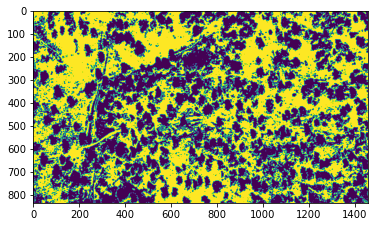

<Figure size 1440x1008 with 0 Axes>

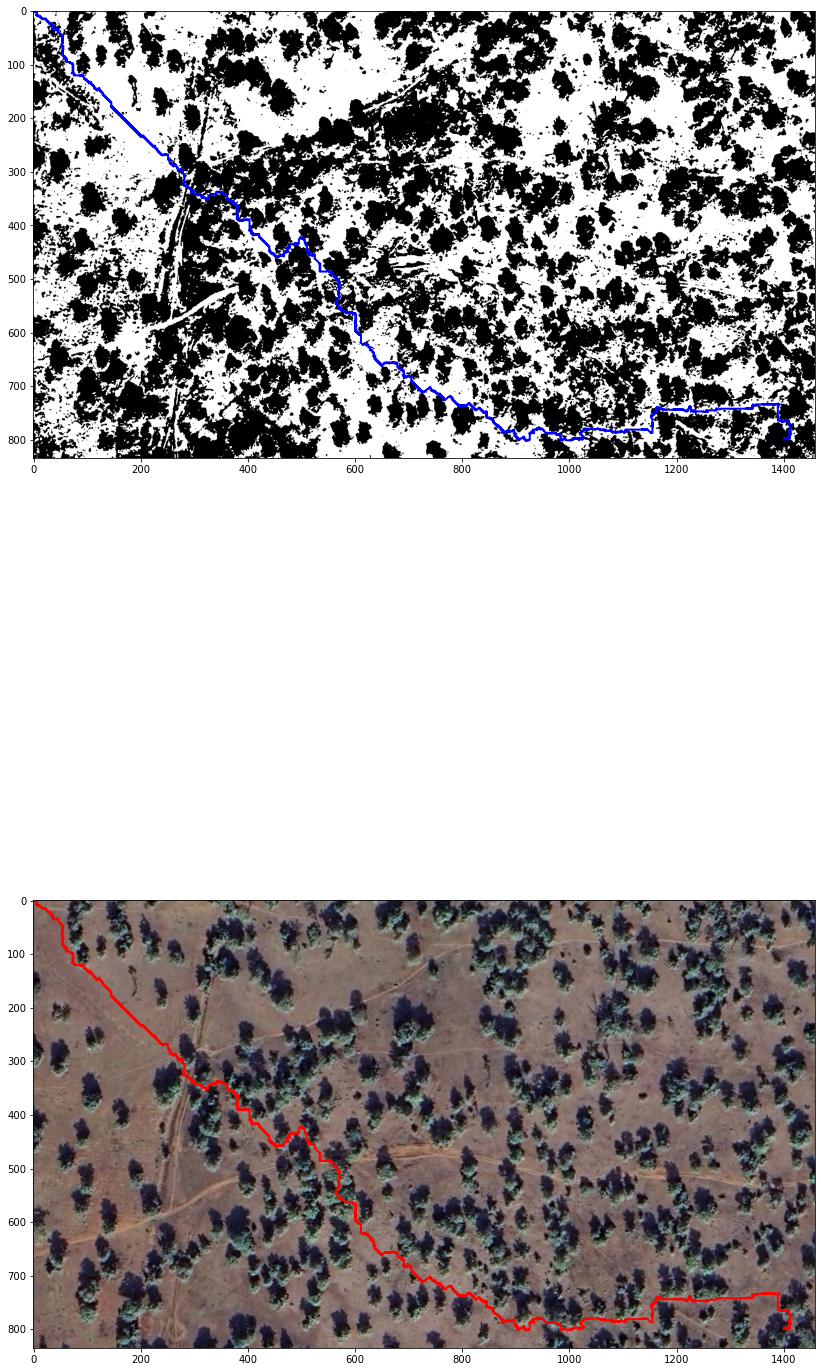

In [19]:
if __name__ == "__main__":
    PATH = r"C:/Users/91898/Desktop/Prototype/Seg/Web capture_8-9-2023_232221_earth.google.com.jpeg"
    obj = ImageSeg(PATH)
    img = obj.IsoGrayThresh()
    obj = OptimalPathing(img,PATH)
    obj.ComputeDjikstra()
    

In [ ]:
d